In [1]:
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import uniform,norm,t,binom,expon,chi2,gamma,poisson,beta,dirichlet
from scipy.stats import multivariate_normal as multi_norm
from sklearn.linear_model import LinearRegression as Linear
from scipy.optimize import brentq
from scipy.special import perm,comb
import time
import pandas as pd

**8.1**

In [2]:
def increasing(theta):
    f=lambda x: x**theta
    X=uniform.rvs(size=10000)
    print(np.corrcoef(f(X),f(1-X))[0,1])

In [3]:
increasing(1)
increasing(2)
increasing(4)
increasing(8)
increasing(16)
increasing(32)
increasing(64)
increasing(128)

-1.0
-0.8758349938574427
-0.5406158212955993
-0.25986378734908366
-0.12462028253685989
-0.06345276688742367
-0.0326110803793967
-0.01571083031135427


**8.4**

In [4]:
f=lambda x: 100*(x>0.9)*(x<=0.91)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'<',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

49.268768639999976 < 50.279997439999995
1.0072 0.009985266554278859
0.9845 0.00982402766180959


In [5]:
f=lambda x: 100*(x>0.45)*(x<=0.55)
size=1000000
X=uniform.rvs(size=size)
fe=lambda x: (f(x)+f(1-x))/2
fo=lambda x: (f(x)-f(1-x))/2
print(np.var(fe(X)),'>',np.var(fo(X)))
print(np.mean(f(X)),np.std(f(X))/np.sqrt(size))
X=uniform.rvs(size=int(size/2))
fx=(f(X)+f(1-X))/2
print(np.mean(fx),np.std(fx)/np.sqrt(size/2))

898.7837689600003 > 0.0
9.9848 0.029979722629804303
10.0334 0.04248931358447673


**8.7**

In [6]:
def BB_params(m,s):
    u=np.int64(-1*np.ones(m))
    v=np.int64(-1*np.ones(m))
    a=np.zeros(m)
    b=np.zeros(m)
    w=np.zeros(m)
    for j in range(m):
        sub=s[:j][s[:j]<s[j]]
        u[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.max(sub))
        sub=s[:j][s[:j]>s[j]]
        v[j]=-1 if len(sub)==0 else np.argmax(s[:j]==np.min(sub))
        if u[j]>=0 and v[j]>=0:
            l=s[u[j]]
            r=s[v[j]]
            a[j]=(r-s[j])/(r-l)
            b[j]=(s[j]-l)/(r-l)
            w[j]=np.sqrt((s[j]-l)*(r-s[j])/(r-l))
        elif u[j]>=0:
            l=s[u[j]]
            a[j]=1
            w[j]=np.sqrt(s[j]-l)
        elif v[j]>=0:
            r=s[v[j]]
            b[j]=s[j]/r
            w[j]=np.sqrt(s[j]*(r-s[j])/r)
        else:
            w[j]=np.sqrt(s[j])
            
    return u,v,a,b,w

def conBMviaBB(m,s,z,params,Bint):
    u,v,a,b,w=params
    B=np.zeros(m)
    k=len(Bint)
    B[:k]=Bint
    for j in range(k,m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

def BMviaBB(m,s,z,params):
    u,v,a,b,w=params
    B=np.zeros(m)
    for j in range(m):
        B[j]=w[j]*z[j]
        if u[j]>=0:
            B[j]+=a[j]*B[u[j]]
        
        if v[j]>=0:
            B[j]+=b[j]*B[v[j]]
            
    return B

In [7]:
def straBM(M,N,i,draw):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    if draw:
        plt.plot(np.sort(t),B)
        
    return B

def straGenBM(M,N,i,draw,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    X=delta*np.sort(T*t)+sigma*np.sqrt(T)*B
    if draw:
        plt.plot(np.sort(T*t),X)
        
    return X

def straGBM(M,N,i,draw,S0,delta,sigma,T):
    B1=norm.ppf((i-uniform.rvs())/N)
    t=np.linspace(0,1-1/M,M)
    t=np.append(1,t)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=conBMviaBB(M+1,t,Z,params,[B1])[np.argsort(t)]
    S=S0*np.exp((delta-sigma**2/2)*np.sort(T*t)+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(np.sort(T*t),S)
        
    return S

def GBM(M,N,draw,S0,delta,sigma,T):
    t=np.linspace(0,1,M+1)
    params=BB_params(M+1,t)
    Z=norm.rvs(size=M+1)
    B=BMviaBB(M+1,t,Z,params)
    S=S0*np.exp((delta-sigma**2/2)*T*t+sigma*np.sqrt(T)*B)
    if draw:
        plt.plot(T*t,S)
        
    return S

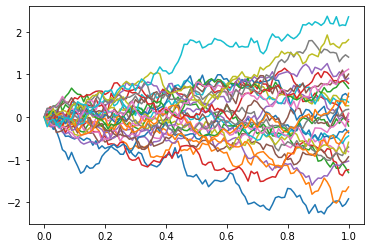

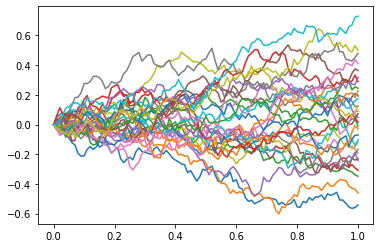

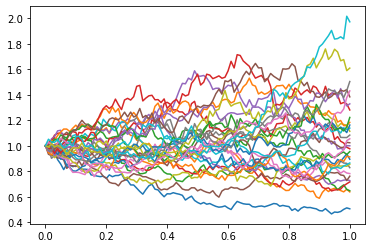

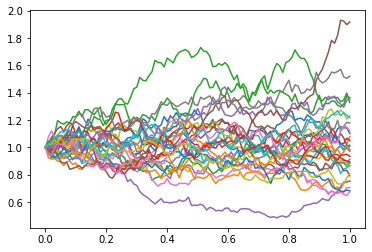

In [8]:
M=100
N=30
draw=True
for i in range(N):
    straBM(M,N,i+1,draw)
    
plt.show()

delta=0.05
sigma=0.3
T=1
for i in range(N):
    straGenBM(M,N,i+1,draw,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    
plt.show()

S0=1
for i in range(N):
    GBM(M,N,draw,S0,delta,sigma,T)
    
plt.show()

In [9]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=straGBM(M,N,i+1,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.46208154401105855 0.0043988439822213125
6.0254762172698975


In [10]:
M=100
N=1000
draw=False
delta=0.05
sigma=0.3
T=1
S0=1
F=np.zeros(2*N)
start=time.time()
for i in range(N):
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i]=S.max()-S.min()
    S=GBM(M,N,draw,S0,delta,sigma,T)
    F[2*i+1]=S.max()-S.min()
    
end=time.time()
print(F.mean(),F.std()/np.sqrt(2*N))
print(end-start)

0.464630931053425 0.0044368290496405146
3.841150999069214


**8.9**

In [11]:
g=lambda x: np.sqrt(5/4+np.cos(2*np.pi*x))
f=lambda x,y: np.exp(g(x)*y)
h=lambda x: (np.exp(g(x))-1)/g(x)
size=10000000

start=time.time()
X=uniform.rvs(size=size)
Y=uniform.rvs(size=size)
E1=np.mean(f(X,Y))
end=time.time()
t1=end-start
print(E1,t1)

start=time.time()
X=uniform.rvs(size=size)
E2=np.mean(h(X))
end=time.time()
t2=end-start
print(E2,t2)

print(np.var(f(X,Y)),np.var(h(X)),(np.var(f(X,Y))*t2)/(np.var(h(X))*t1))

1.8277434869496916 0.5655279159545898
1.8274669975328333 0.5992119312286377
0.5519693812081123 0.12725480934391367 4.595864196055595


In [12]:
g=lambda x: np.sqrt(1+np.cos(2*np.pi*x))
f=lambda x,y: np.exp(g(x)*y)
h=lambda x: (np.exp(g(x))-1)/g(x)
size=10000000

start=time.time()
X=uniform.rvs(size=size)
Y=uniform.rvs(size=size)
E1=np.mean(f(X,Y))
end=time.time()
t1=end-start
print(E1,t1)

start=time.time()
X=uniform.rvs(size=size)
E2=np.mean(h(X))
end=time.time()
t2=end-start
print(E2,t2)

print(np.var(f(X,Y)),np.var(h(X)),(np.var(f(X,Y))*t2)/(np.var(h(X))*t1))

1.6826481018162887 0.5270059108734131
1.6826331743718501 0.6557130813598633
0.46765876895266 0.15181272912041058 3.8328273431391904


**8.10**

In [13]:
df=pd.read_csv('data/ch8.8.10.csv')
data=df.values
print(data.shape)
num=data[:,0]
alpha1=data[:,1]+1
alpha2=data[:,2]+1

(38, 3)


In [14]:
def roulette(num,alpha,wheel,size):
    def h(x):
        y=np.ones_like(x)*1.0
        for a in alpha[num!=wheel]:
            y*=gamma.cdf(x,a=a)

        return y

    X=gamma.rvs(size=size,a=alpha[num==wheel])
    print('conditional:')
    print(np.mean(h(X)),np.std(h(X))/np.sqrt(size))
    S=dirichlet.rvs(size=size,alpha=alpha)
    S1=S[:,num==wheel].flatten()==S.max(axis=1)
    print('normal:')
    print(np.mean(S1),np.std(S1)/np.sqrt(size))
    S2=S[:,num==wheel].flatten()/S.sum(axis=1)
    print('probability:')
    print(np.mean(S2),np.std(S2)/np.sqrt(size))
    print('alpha:')
    print(alpha[num==wheel]/np.sum(alpha))

In [15]:
size=100000
roulette(num,alpha1,19,size)
print()
roulette(num,alpha2,3,size)
print()
roulette(num,alpha1,36,size)

conditional:
0.6302142774614768 0.001093169961885447
normal:
0.63023 0.0015265652527815506
probability:
0.02862266935410035 1.8611484321773676e-06
alpha:
[0.02862046]

conditional:
0.7393628735609441 0.0009105731574352659
normal:
0.74005 0.0013869967465715265
probability:
0.029579212038965703 2.4381824434263694e-06
alpha:
[0.02958105]

conditional:
0.10559179121234907 0.000605847665769676
normal:
0.10492 0.0009690809749448188
probability:
0.027830880778503625 1.838147106422215e-06
alpha:
[0.02783136]


**8.11**

In [16]:
def roulette(num,alpha,wheel,size):
    S=dirichlet.rvs(size=size,alpha=alpha)
    S1=S[:,num==wheel].flatten()==np.sort(S,axis=1)[:,-2]
    print(np.mean(S1),np.std(S1)/np.sqrt(size))

In [17]:
roulette(num,alpha1,19,10000)

0.1721 0.003774673363352119


**8.14**

In [18]:
def roulette(A,size):
    num=data[:,0]
    alpha1=data[:,1]+A
    alpha2=data[:,2]+A
    def h(x,alpha,wheel):
        y=np.ones_like(x)*1.0
        for a in alpha[num!=wheel]:
            y*=gamma.cdf(x,a=a)

        return y

    X1=gamma.rvs(size=size,a=alpha1[num==19])
    Y1=h(X1,alpha1,19)
    X2=gamma.rvs(size=size,a=alpha2[num==3])
    Y2=h(X2,alpha2,3)
    print(np.mean(Y1),np.mean(Y2))

In [19]:
roulette(1,100000)
roulette(100,100000)
roulette(10000,100000)
roulette(1000000,100000)
roulette(100000000,100000)
roulette(10000000000,100000)
print()
print(1/38)

0.6296113996884659 0.7386659770281562
0.614522081308629 0.7216778929238423
0.2343413027889726 0.22509972929330718
0.037973570019217966 0.03639856863008887
0.027957882579926964 0.027836640491590056
0.026915411783482297 0.026119844225355474

0.02631578947368421


**8.16**

In [20]:
f=lambda x: x**(-0.5)+x
h=lambda x: x**(-0.5)
mu=5/2
theta=2
size=50
R=10000
Beta=np.zeros(R)
Mu0=np.zeros(R)
Mu1=np.zeros(R)
Mu2=np.zeros(R)
for i in range(R):
    X=uniform.rvs(size=size)
    x=(h(X)-theta).reshape(-1, 1)
    y=f(X)
    reg=Linear().fit(x,y)
    Beta[i]=reg.coef_[0]
    x=x.flatten()
    Mu0[i]=np.mean(y-Beta[i]*x)
    Mu1[i]=np.mean(y-x)
    Mu2[i]=np.mean(y-2*x)

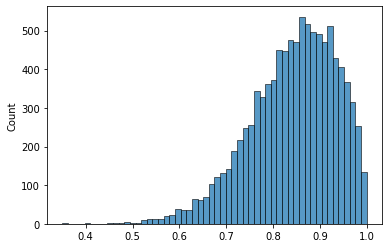

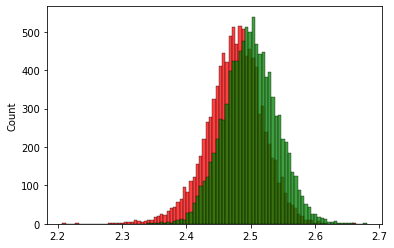

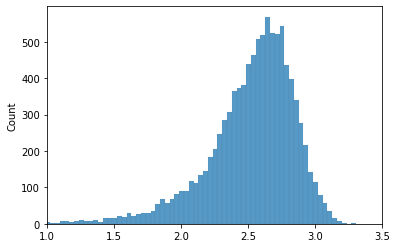

In [21]:
sb.histplot(Beta)
plt.show()
sb.histplot(Mu0,color='r')
sb.histplot(Mu1,color='g')
plt.show()
sb.histplot(Mu2)
plt.xlim([1,3.5])
plt.show()

**8.22**